## <font color='green'> <div align="center">In the name of God </div></font>

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi</font> <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> 

# Initialization of the weights by PCA

### importing general modules

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### importing PyTorch modules

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

## Loading MNIST

In [3]:
MnistTrainX = sio.loadmat ('../../datasets/mnist/MnistTrainX')['MnistTrainX'] / 255;
MnistTrainY = sio.loadmat ('../../datasets/mnist/MnistTrainY')['MnistTrainY'];
MnistTestX  = sio.loadmat ('../../datasets/mnist/MnistTestX')['MnistTestX'] / 255;
MnistTestY  = sio.loadmat ('../../datasets/mnist/MnistTestY')['MnistTestY'];

N = 60000
MnistTrainX = MnistTrainX[:N,:]
MnistTrainY = MnistTrainY[:N,:]
XTrain = MnistTrainX
yTrain = MnistTrainY.squeeze()
XTest = MnistTestX
yTest = MnistTestY.squeeze()
N, dim = XTrain.shape

## Computing PCA

In [4]:
pca = PCA(n_components=784)
pca.fit(XTrain)

PCA(copy=True, iterated_power='auto', n_components=784, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

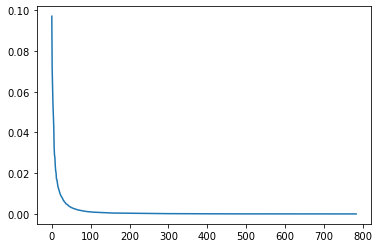

In [5]:
plt.plot(np.arange(784), pca.explained_variance_ratio_)
plt.show()

In [6]:
pca_components = pca.components_[0:70,:]

## Plotting the first 64 PCA components

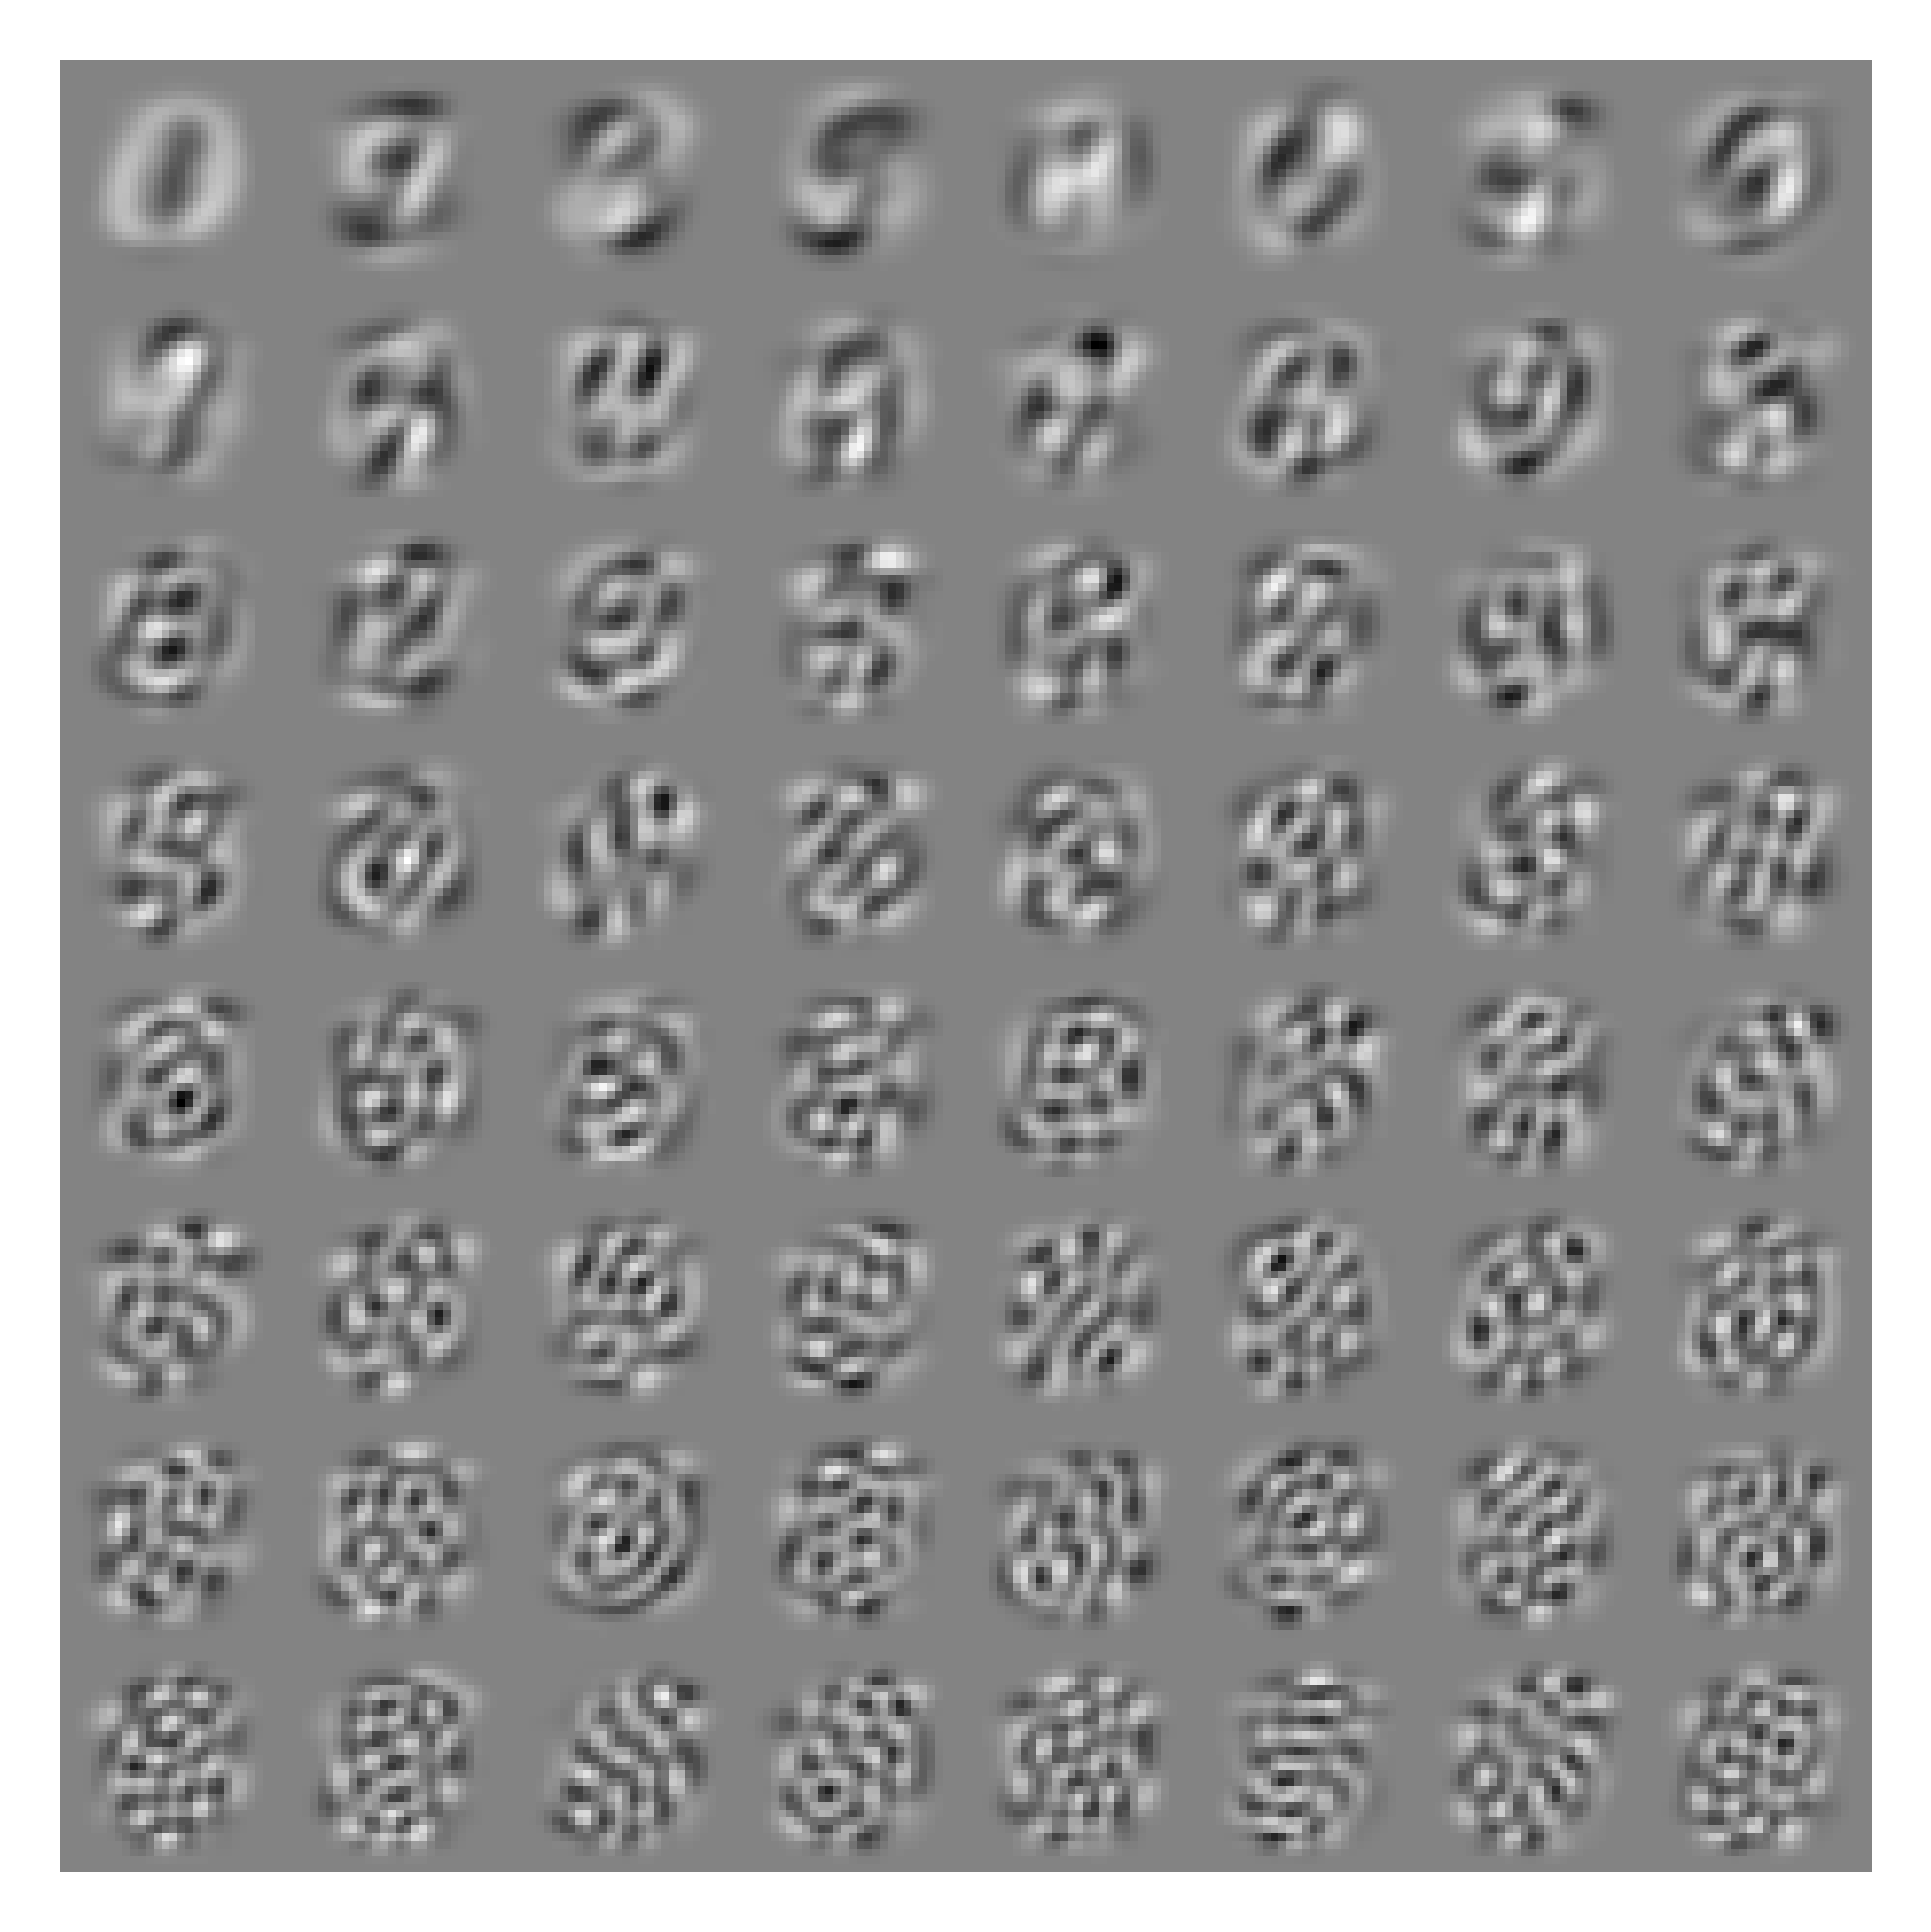

In [7]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 600
img = np.zeros ([8 * 29, 8 * 29])
k = 0
for i in range (8):
    for j in range (8):
        img[i*29:i*29+28,j*29:j*29+28] = np.reshape(pca_components[k],(28,28))
        k+=1
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()        

## Defining the MLFF network by inheriting from nn.Module

Note that the following command is crucial:

``
self.layers = nn.ModuleList(layersList)
``

In [8]:
class MLFF(nn.Module):
    def __init__(self, layersNeuronCount, pca_components):
        super().__init__()
        self.layersCount = len (layersNeuronCount) - 1
        layersList = [None] * self.layersCount
        for i in range (self.layersCount):
            layersList[i] = nn.Linear(layersNeuronCount[i], layersNeuronCount[i+1])
        self.layers = nn.ModuleList(layersList)
        assert (pca_components.T.shape == tuple(layersNeuronCount[0:2]))
        self.layers[0].weight.data = torch.tensor (pca_components, dtype=torch.float)
    
    def forward(self, x):
        for i in range (self.layersCount):
            x = self.layers[i](x)
            if (i < self.layersCount - 1):
                x = torch.relu(x)
        return x

In [9]:
net = MLFF([784, 70, 40, 10], pca_components)
print (net)

MLFF(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=70, bias=True)
    (1): Linear(in_features=70, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=10, bias=True)
  )
)


In [11]:
print (np.linalg.norm( net.layers[0].weight.data.detach().numpy() - pca_components))

2.1138413222969258e-07


### Choosing device

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


## Optimization

In [57]:
num_epochs = 5
batch_size = 100
report_after_X_iterations = 600
learning_rate = 0.1
num_batches = N // batch_size

In [58]:
net.to(device)

optimizer = optim.SGD(net.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range (num_epochs):
    for itr in range (num_batches):
        X = torch.tensor (MnistTrainX[itr*batch_size:(itr+1)*batch_size,:], dtype=torch.float)
        T = MnistTrainY[itr*batch_size:(itr+1)*batch_size]
        T = torch.tensor (T.squeeze(), dtype = torch.long)
        X = X.to(device)
        T = T.to(device)
        output = net(X)
        loss = criterion(output, T)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((itr+report_after_X_iterations-1) % report_after_X_iterations == 0):
            print('\n---- iteration #{0} of {1} at epoch #{2} of {3} ---- :'.format(
                itr, num_batches, epoch, num_epochs))
            score = 0.0
            for i in range(num_batches):
                X = MnistTrainX[i * batch_size:(i + 1) * batch_size, :]
                T = MnistTrainY[i * batch_size:(i + 1) * batch_size]
                T = T.squeeze()
                X = torch.tensor(X, dtype=torch.float).to(device)
                #T = torch.tensor(T, dtype=torch.long).to(device)
                output = net(X)
                prediction = torch.argmax(output, dim=1).numpy()
                score += np.sum(prediction == T)
            score /= N
            score *= 100
            print('Loss = {0}, Accuracy on training data = {1}%'.format(loss.item(), score))


---- iteration #1 of 600 at epoch #0 of 5 ---- :
Loss = 2.2585952281951904, Accuracy on training data = 14.378333333333334%

---- iteration #1 of 600 at epoch #1 of 5 ---- :
Loss = 0.27911868691444397, Accuracy on training data = 91.28500000000001%

---- iteration #1 of 600 at epoch #2 of 5 ---- :
Loss = 0.2040397971868515, Accuracy on training data = 93.58333333333333%

---- iteration #1 of 600 at epoch #3 of 5 ---- :
Loss = 0.18105623126029968, Accuracy on training data = 94.85333333333334%

---- iteration #1 of 600 at epoch #4 of 5 ---- :
Loss = 0.16967618465423584, Accuracy on training data = 95.70166666666667%


In [59]:
print (np.linalg.norm( net.layers[0].weight.data.detach().numpy() - pca_components))

6.264024590774185


## Plotting the PCA weights after training

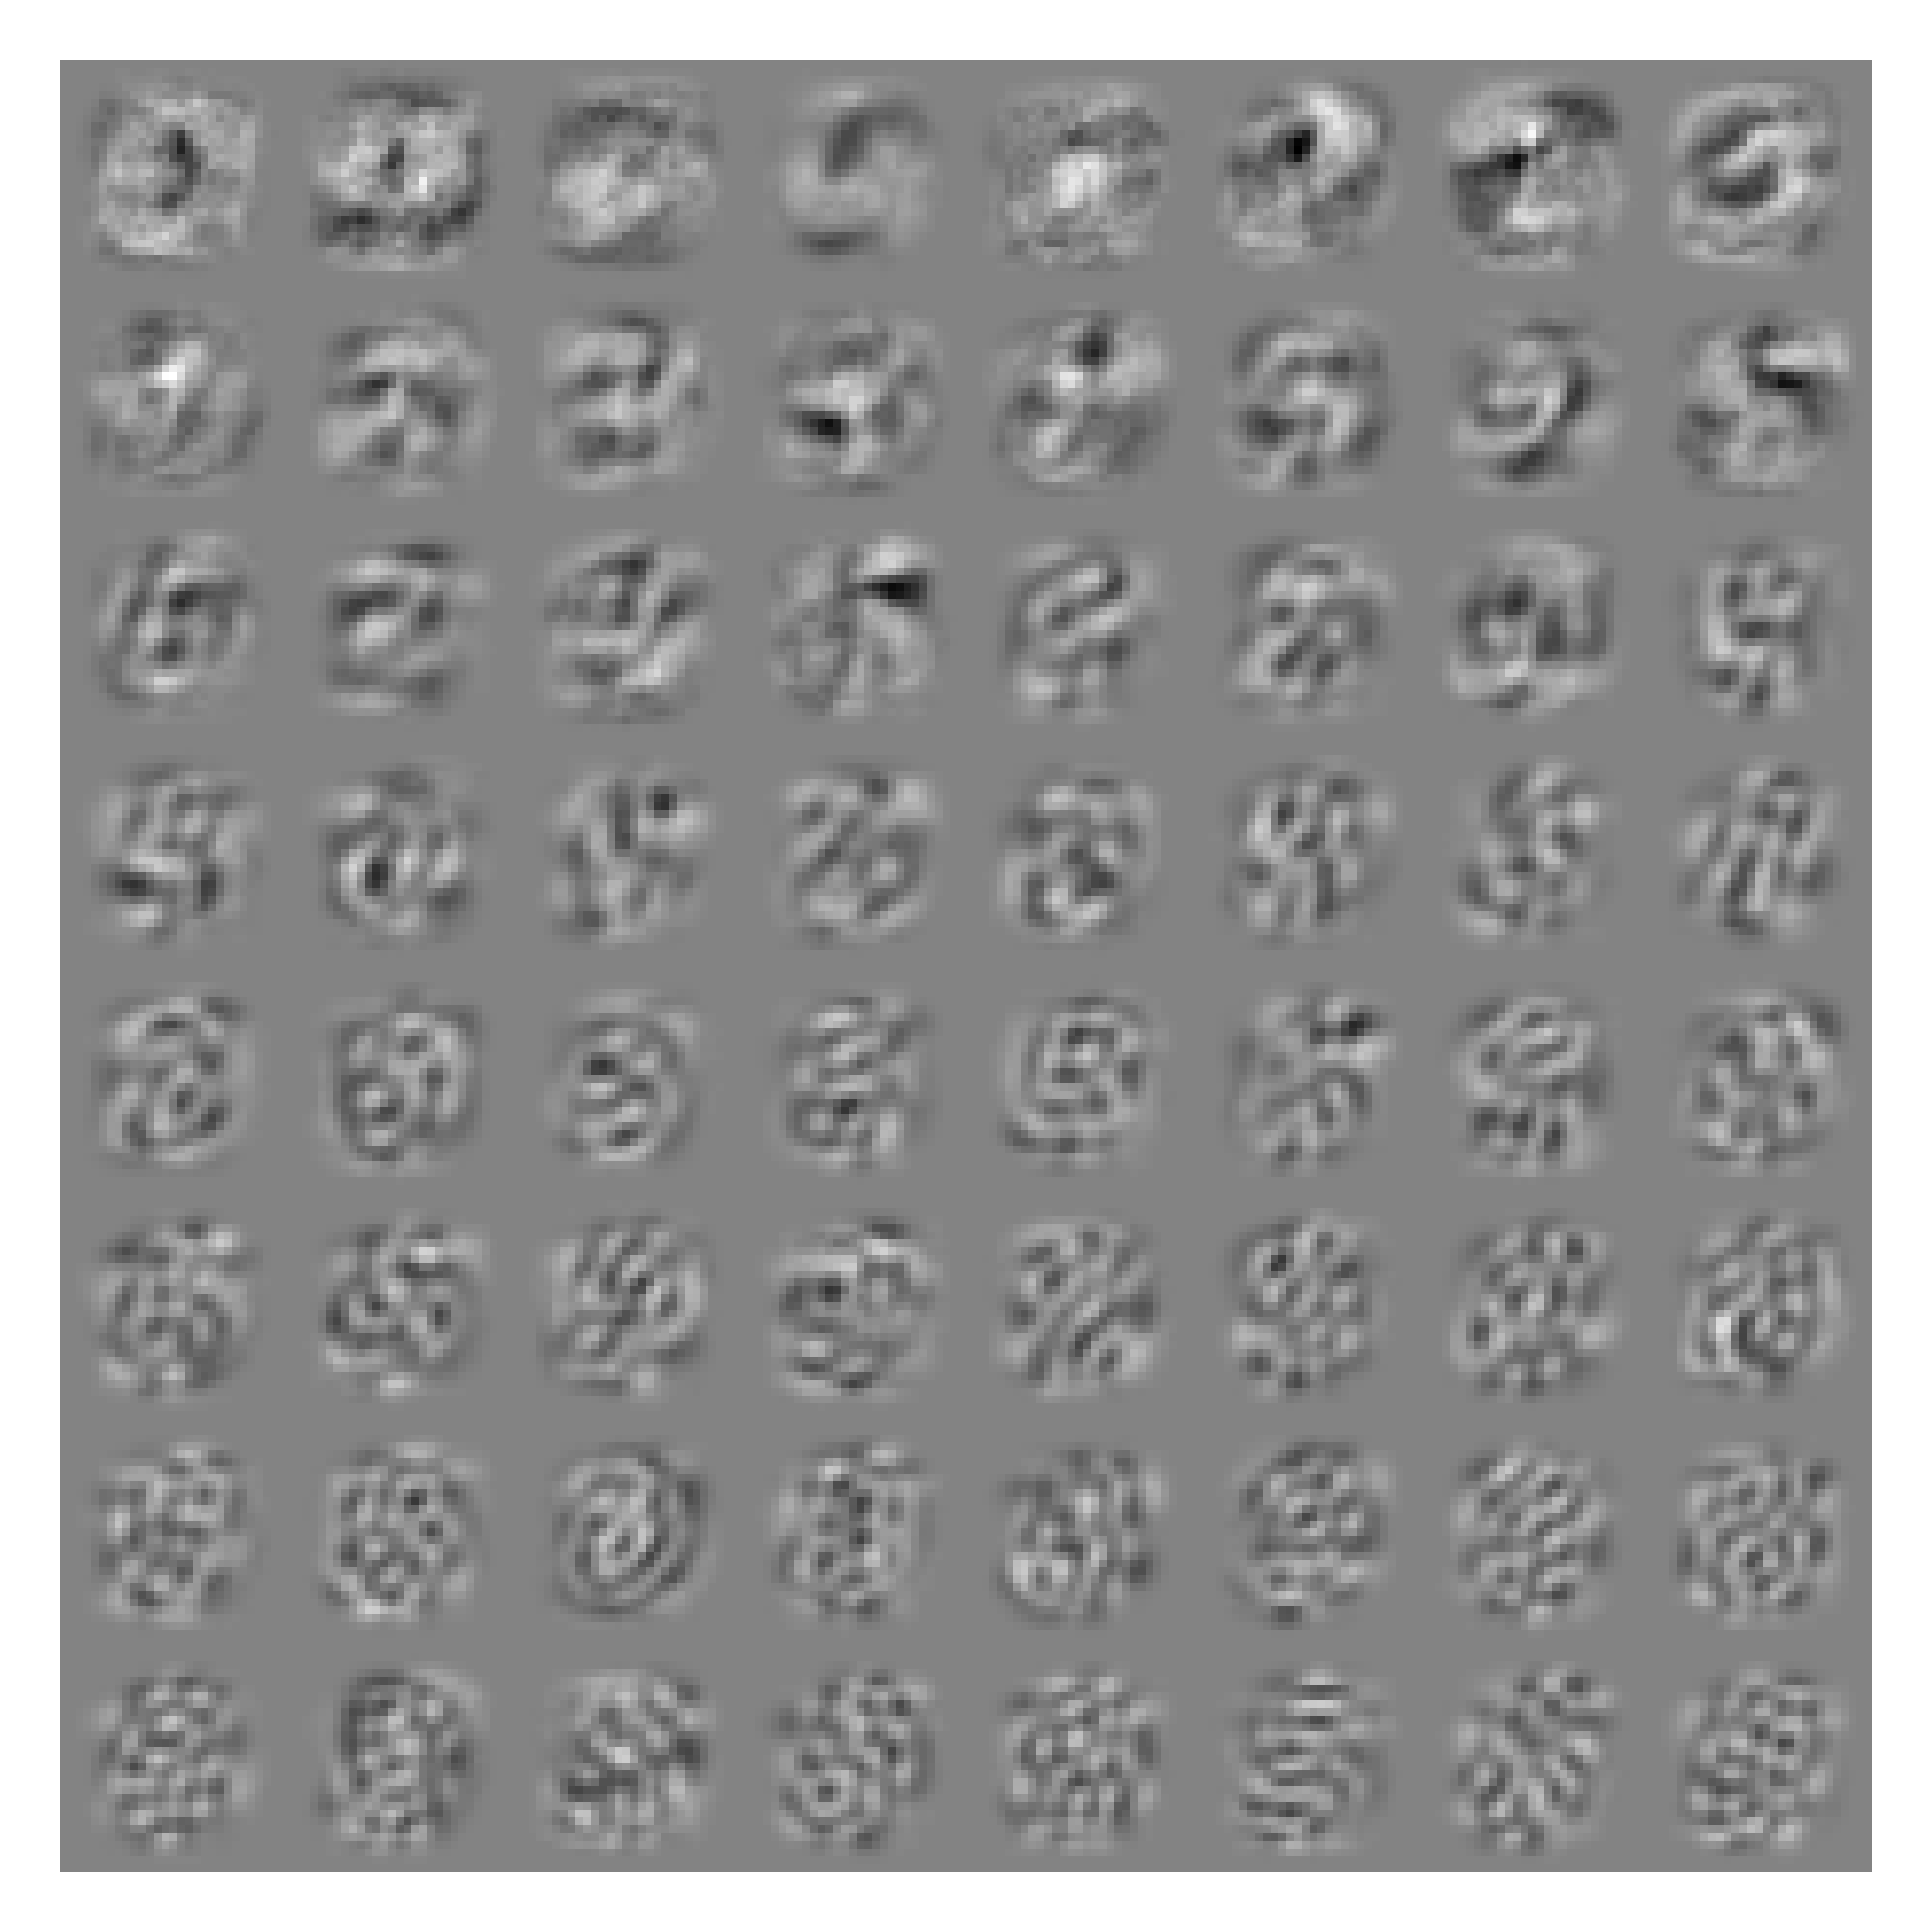

In [71]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 600
img = np.zeros ([8 * 29, 8 * 29])
k = 0
for i in range (8):
    for j in range (8):
        img[i*29:i*29+28,j*29:j*29+28] = np.reshape(net.layers[0].weight.data[k,:],(28,28))
        k+=1
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()